## 0.Import Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers

## 1. Load Dataset

In [4]:
dir = 'refined_dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']
The number of dataset : 8


In [5]:
num = ['B05', 'B07', 'B18', 'B33', 'B34', 'B46', 'B47', 'B48']
for i in range(len(listdir)):
    vector = np.zeros((1,3))
    path = os.path.join(os.getcwd(), 'refined_dataset/', num[i] + '_discharge_soh.csv')
    csv = pd.read_csv(path)
    df = pd.DataFrame(csv)
    
    vec = df[['cycle', 'capacity', 'SOH']]
    
    globals()['data_{}'.format(num[i])] = vec

In [6]:
data = pd.read_csv('refined_dataset/B33_discharge_soh.csv')
df = pd.DataFrame(data)
df

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.200502,-0.002575,23.819756,0.0004,0.000,0.000,1.713169,8,0.856585
1,4.200289,-0.002829,23.811627,0.0006,4.215,9.297,1.713169,8,0.856585
2,3.472020,-4.024851,23.996330,3.9950,1.519,19.813,1.713169,8,0.856585
3,3.432302,-4.025356,24.502166,3.9950,1.498,29.579,1.713169,8,0.856585
4,3.401729,-4.026066,25.093116,3.9950,1.475,39.344,1.713169,8,0.856585
...,...,...,...,...,...,...,...,...,...
42195,3.700989,-0.004594,28.979655,0.0004,0.000,2765.329,1.315283,197,0.657641
42196,3.700967,-0.000881,28.905148,0.0004,0.000,2781.407,1.315283,197,0.657641
42197,3.701200,-0.002798,28.822990,0.0004,0.000,2797.454,1.315283,197,0.657641
42198,3.701104,-0.003812,28.757153,0.0004,0.000,2813.469,1.315283,197,0.657641


<Axes: >

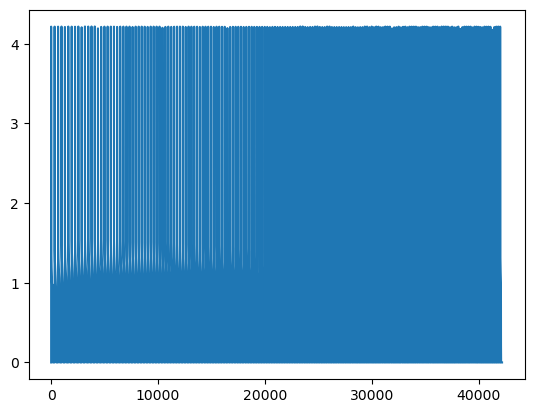

In [7]:
df['charge_voltage'].plot()

In [8]:
data_B18  ## result

,cycle,capacity,SOH
0,1,1.855005,0.927502
1,1,1.855005,0.927502
2,1,1.855005,0.927502
3,1,1.855005,0.927502
4,1,1.855005,0.927502
...,...,...,...
34861,132,1.341051,0.670526
34862,132,1.341051,0.670526
34863,132,1.341051,0.670526
34864,132,1.341051,0.670526


In [9]:
for i in range(len(listdir)):
    print("Shape of data :", np.shape(globals()['data_{}'.format(num[i])]))

Shape of data : (50285, 3)
Shape of data : (50285, 3)
Shape of data : (34866, 3)
Shape of data : (42200, 3)
Shape of data : (45909, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)


In [10]:
print(listdir)
dataset = data_B48["SOH"]
cycle = data_B48['cycle']

dataset = np.array(dataset)
dataset = dataset.reshape((len(dataset),1))
dataset.shape

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']


(23478, 1)

## 2. Split train and test dataset

In [11]:
dataset.shape

(23478, 1)

In [12]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(dataset)

In [13]:
train_size = int(len(dataset_scaled) * 0.9)
# train_size = int(len(dataset) * 0.5)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset_scaled),:]
print(len(train), len(test))

21130 2348


In [14]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

21129
2347


In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(21129, 1, 1)
(2347, 1, 1)


## 3. Training with LSTM

In [17]:
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

C:\Users\NILA_HOME\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
history = model.fit(trainX, trainY, epochs=40, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle = False)

Epoch 1/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3280 - val_loss: 0.0455
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1191 - val_loss: 0.0338
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0748 - val_loss: 0.0275
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0480 - val_loss: 0.0148
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0087
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0031
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084 - val_loss: 0.0018
Epoch 10/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - val_loss: 0.0017
Epoch 11/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - val_loss: 0.0027
Epoch 12/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [19]:
# save model architecture
model_json = model.to_json()
open('50%/model/B48_model2.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('50%/model/B48_weights2.weights.h5', overwrite=True)

In [20]:
# Load trained model
from keras.models import model_from_json 

json_file = open("50%/model/B48_model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("50%/model/B48_weights.h5")
print("Loaded model from disk")

Loaded model from disk


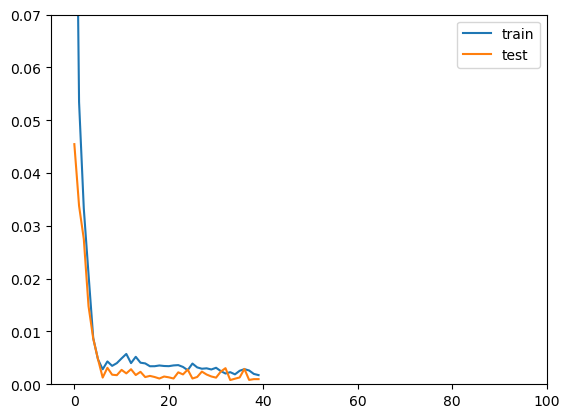

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.axis([-5, 100, 0, 0.07])
plt.legend() 
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
661/661 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step


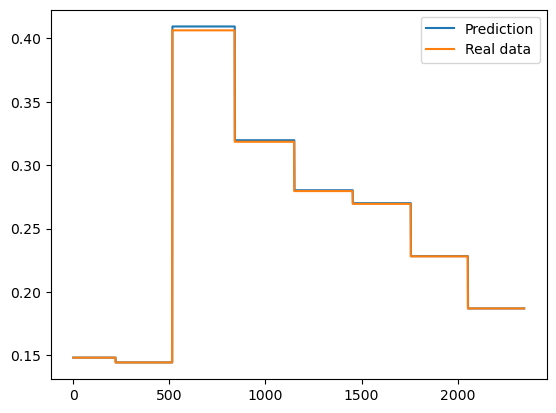

In [22]:
yhat = model.predict(testX)
tyhat = model.predict(trainX)
plt.plot(yhat, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

In [23]:
print("Shape of train data :", trainX.shape)
print("Shape of prediction :", yhat.shape)
print("Shape of real data :", testY.shape)

Shape of train data : (21129, 1, 1)
Shape of prediction : (2347, 1)
Shape of real data : (2347,)


In [24]:
rmse = math.sqrt(mean_squared_error(testY, yhat))
mae = mean_absolute_error(testY, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.006
Test MAE: 0.001


## 4. Visualization

In [25]:
print("Shape of cycle :", np.shape(cycle))

cycle1 = cycle[0:train_size-1]
cycle2 = cycle[train_size+1:len(dataset)]

# cycle1 = cycle[0:train_size]
# cycle2 = cycle[train_size:len(dataset)]

print(np.shape(cycle1), np.shape(cycle2))

Shape of cycle : (23478,)
(21129,) (2347,)


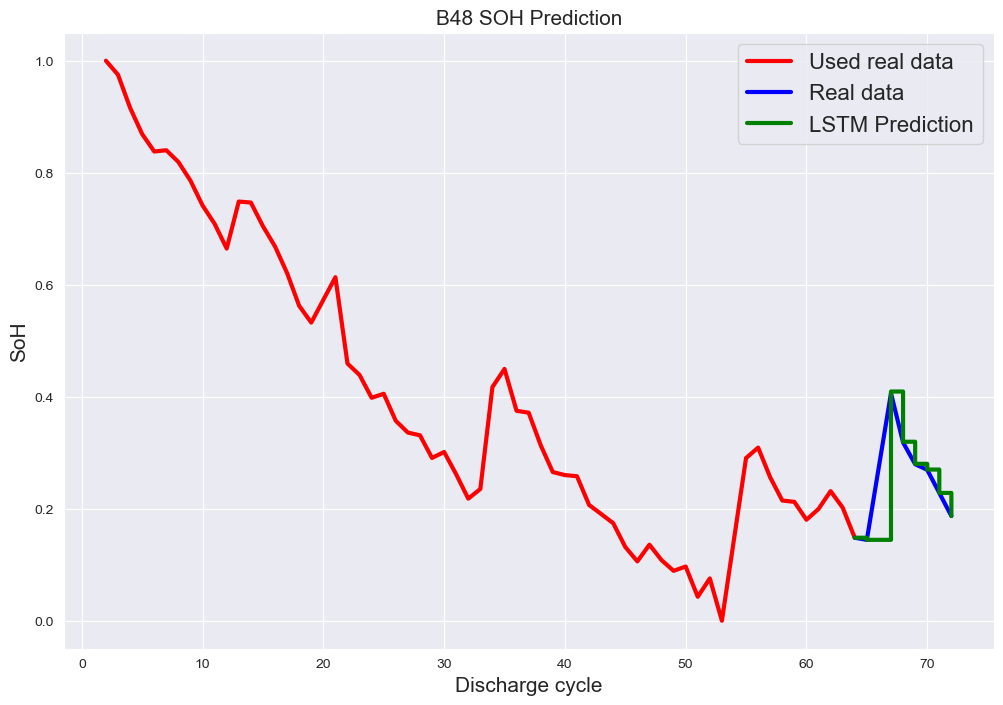

In [26]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))

plt.plot(cycle1, trainX[:,0],label='Used real data', linewidth = 3, color='r')
plt.plot(cycle2, testY,label='Real data', linewidth = 3, color='b')
# plt.plot(cycle2, yhat[:,0],label='LSTM Prediction', linewidth = 3, color='g')
plt.plot(cycle2, yhat[:,0],label='LSTM Prediction', linewidth = 3, color='g')
plt.legend(prop={'size': 16})

plt.ylabel('SoH', fontsize = 15)
plt.xlabel('Discharge cycle', fontsize = 15)
plt.title(str(num[7]) + " SOH Prediction", fontsize = 15)
plt.savefig('50%/fig/' + str(num[7]) + '_LSTM.jpg')
plt.show()

In [27]:
testX.shape

(2347, 1, 1)

In [28]:
print(listdir)

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']


In [29]:
data_B05

,cycle,capacity,SOH
0,1,1.856487,0.928244
1,1,1.856487,0.928244
2,1,1.856487,0.928244
3,1,1.856487,0.928244
4,1,1.856487,0.928244
...,...,...,...
50280,168,1.325079,0.662540
50281,168,1.325079,0.662540
50282,168,1.325079,0.662540
50283,168,1.325079,0.662540


In [30]:
test_soh = data_B05['SOH'].values
test_values = test_soh.reshape(len(test_soh),1)
test_scaled = scaler.fit_transform(test_values)

In [31]:
test_scaled.shape

(50285, 1)

In [32]:
datab = test_scaled

In [33]:
test_scaled = np.reshape(test_scaled, (len(test_scaled), 1, trainX.shape[1]))
test_scaled.shape

(50285, 1, 1)

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


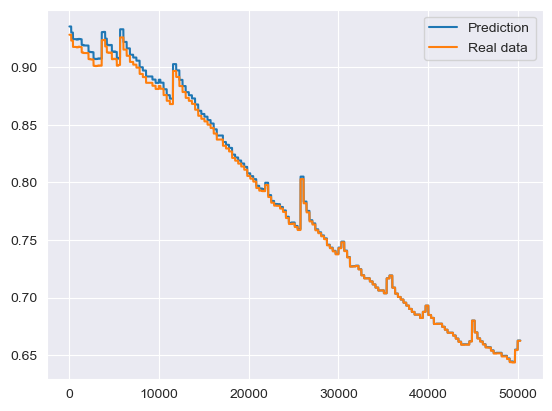

In [34]:
yhat_6 = model.predict(test_scaled)
yhat_6_inv  = scaler.inverse_transform(yhat_6)
plt.plot(yhat_6_inv , label='Prediction')
plt.plot(test_soh, label='Real data')
plt.legend()
plt.show()